##Human Activity Recognition using Smart Phones

### Installing the required libraries

In [ ]:
!pip install 'umap-learn==0.3.10'

     |████████████████████████████████| 40 kB 3.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.3.10-py3-none-any.whl size=38881 sha256=d8f2ec6aa11b6d1131fc88a7eb6f2e609126b7dee18704b115b3c297c79946c7
  Stored in directory: /root/.cache/pip/wheels/ea/d0/8f/9e64bfc5ed0645f89b639196bef92daf5c704285133efce12f
Successfully built umap-learn


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
sns.set()
import time
current_palette = sns.color_palette()
import umap
import matplotlib
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

### Fetching the data

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

--2022-03-26 23:40:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  42.5MB/s    in 1.4s    

2022-03-26 23:40:41 (42.5 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]



In [ ]:
!unzip '/content/UCI HAR Dataset.zip'

Archive:  /content/UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating

In [ ]:
# Reading the labels data
lab1 = pd.read_csv('/content/UCI HAR Dataset/train/y_train.txt',header=None)
lab2 = pd.read_csv('/content/UCI HAR Dataset/test/y_test.txt',header=None)
label = pd.concat([lab1,lab2],ignore_index=True)
activity = pd.read_csv('/content/UCI HAR Dataset/activity_labels.txt',header=None,sep=' ')
act = activity.set_index(0).to_dict()[1]
for i,j in act.items():
  label.loc[label[0]==i,'Activity']=j

label.columns= ['Label','Activity']
label


,Label,Activity
0,5,STANDING
1,5,STANDING
2,5,STANDING
3,5,STANDING
4,5,STANDING
...,...,...
10294,2,WALKING_UPSTAIRS
10295,2,WALKING_UPSTAIRS
10296,2,WALKING_UPSTAIRS
10297,2,WALKING_UPSTAIRS


In [ ]:
# Reading the features data
names = pd.read_csv('/content/UCI HAR Dataset/features.txt',header=None,sep=' ')
train = pd.read_csv('/content/UCI HAR Dataset/train/X_train.txt', delim_whitespace=True,header=None)
test = pd.read_csv('/content/UCI HAR Dataset/test/X_test.txt', delim_whitespace=True,header=None)
features = pd.concat([train,test],ignore_index=True)
features.columns = list(names[1])
features

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,...,0.074472,-0.376278,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784
10295,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,...,0.101859,-0.320418,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412
10296,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,...,-0.066249,-0.118854,-0.467179,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184
10297,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,...,-0.046467,-0.205445,-0.617737,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563


In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 44.1 MB


### Data Processing

In [ ]:
#checking for null values
print(f'There {features.isnull().any().sum()} null values in the data')

There 0 null values in the data


In [ ]:
# Finding duplicate features
print('Number of features: ',len(names[1]))
print('Number of unique features name: ',names[1].nunique())

#printing to check if the features with same name are duplicate
same_features =[]
for i in range(len(names[1].value_counts())):
  if names[1].value_counts()[i]>1:
    same_features.append(names[1].value_counts().index[i])

features[same_features[0]].head()

Number of features:  561
Number of unique features name:  477


,"fBodyAccJerk-bandsEnergy()-41,48","fBodyAccJerk-bandsEnergy()-41,48","fBodyAccJerk-bandsEnergy()-41,48"
0,-0.999640,-0.999729,-0.999814
1,-0.999814,-0.999685,-0.999769
2,-0.999906,-0.999627,-0.999626
3,-0.999930,-0.999846,-0.999735
4,-0.999929,-0.999769,-0.999688


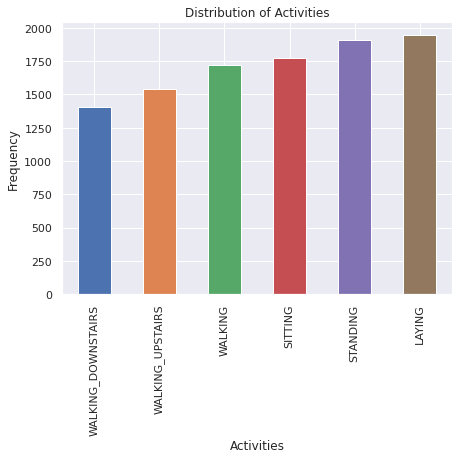

In [ ]:
#Visualizing the distribution of various activities
fig,ax = plt.subplots(figsize =(7, 5))
label['Activity'].value_counts().sort_values().plot(kind = 'bar', color = current_palette)
ax.set_xlabel('Activities')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Activities')
plt.show()

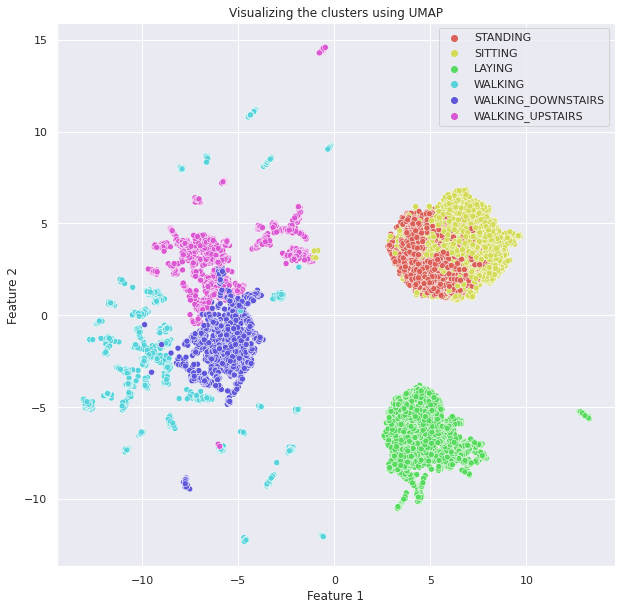

In [ ]:
#Visualizing the clusters
dm = umap.UMAP(min_dist=0.3,random_state=123)
embedding = dm.fit_transform(features)
embedding = pd.DataFrame(embedding)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(embedding[0], embedding[1],hue=label.Activity.tolist(),
                palette=sns.color_palette("hls", 6))
ax.set_title('Visualizing the clusters using UMAP')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

In [ ]:
#Function for visualing DBSCAN clusters
def visualize(data, labels):
  plt.figure(figsize=(10,10))
  sns.scatterplot(data[0],data[1] ,hue=labels,
                palette=sns.color_palette("hls", (int)(pd.DataFrame(labels).nunique())),s=15)
  plt.title('DBSCAN Clustering',fontsize=20)
  plt.xlabel('Feature 1',fontsize=14)
  plt.ylabel('Feature 2',fontsize=14)
  plt.show()

In [ ]:
# Function for plotting k-distance graph
def parameter_tuning(data):
  neigh = NearestNeighbors(n_neighbors=2)
  nbrs = neigh.fit(data)
  distances, indices = nbrs.kneighbors(data)

  # Plotting K-distance Graph
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  plt.figure(figsize=(20,10))
  plt.plot(distances)
  plt.title('K-distance Graph',fontsize=20)
  plt.xlabel('Data Points sorted by distance',fontsize=14)
  plt.ylabel('Epsilon',fontsize=14)
  plt.show()

### Clustering without Dimensionality reduction

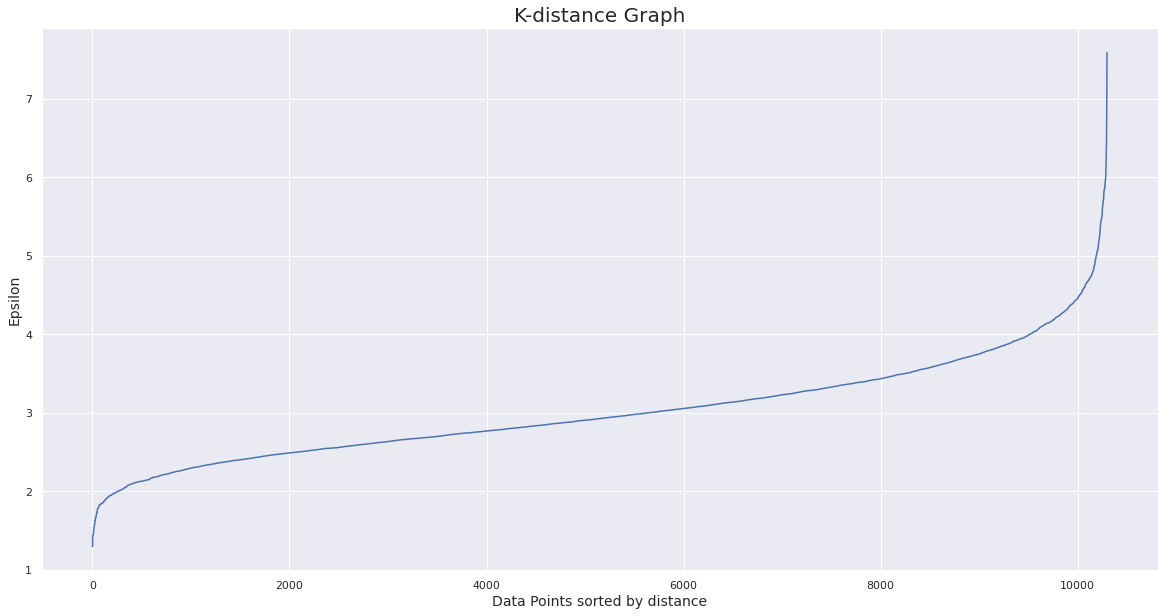

In [ ]:
#Finding the best epsilon value 
parameter_tuning(features)

Number of clusters formed :  3


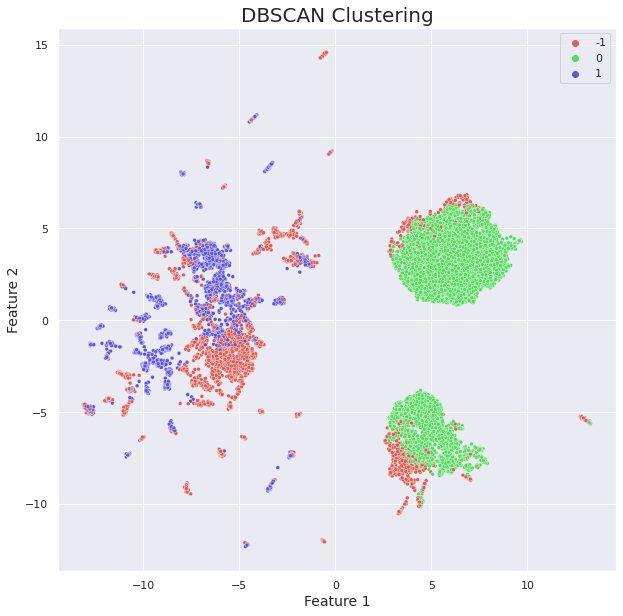

In [ ]:
#Fitting the model with best paramters
start = time.perf_counter()
model1=DBSCAN(eps=4.9,min_samples=1000)
model1.fit(features)
end = time.perf_counter()
without_dr = end -start
print("Number of clusters formed : ",(int)(pd.DataFrame(model1.labels_).nunique()))
visualize(embedding,model1.labels_)

###Clustering with Dimensionality reduction

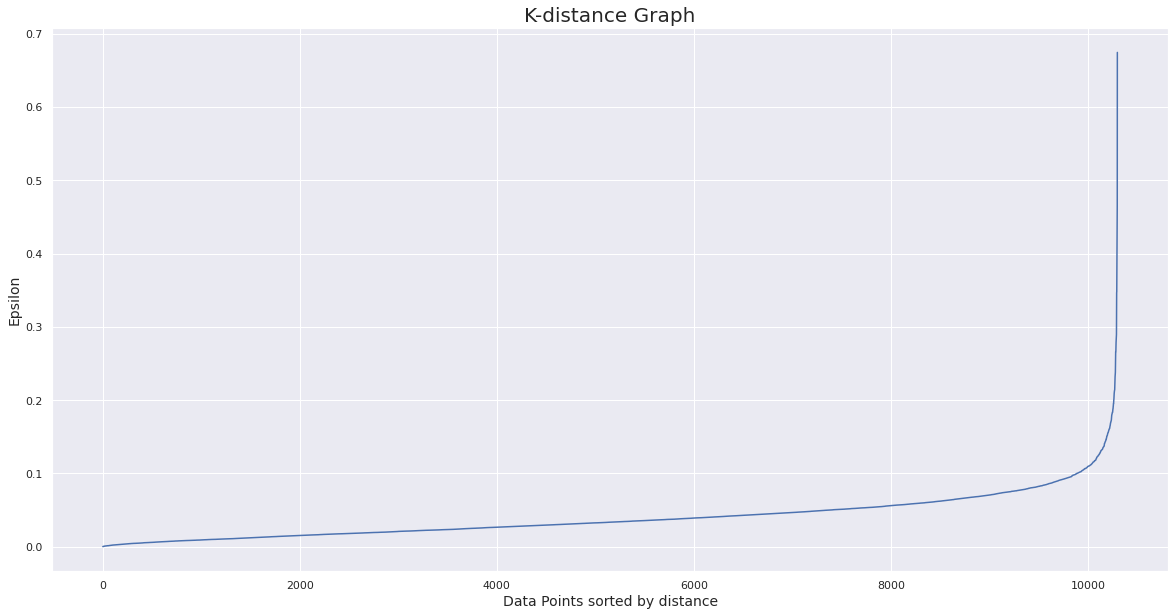

In [ ]:
#Finding the best epsilon value for reduced data
parameter_tuning(embedding)

Number of clusters formed :  6


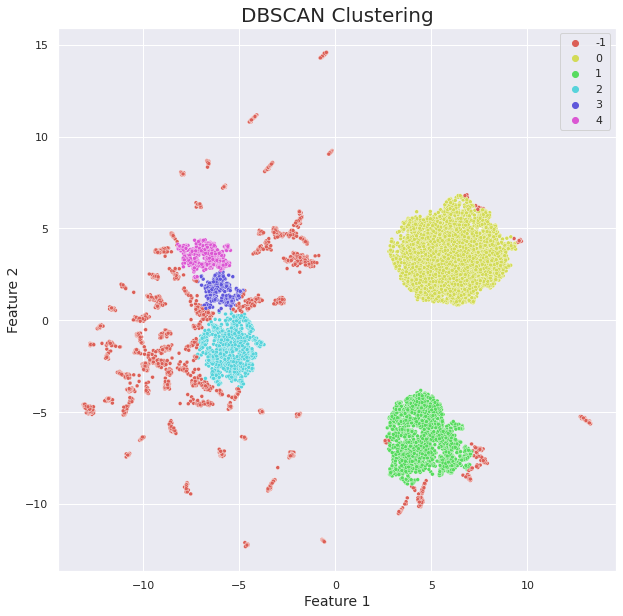

In [ ]:
#Fitting the model with best parameters
start = time.perf_counter()
model2=DBSCAN(eps=0.8,min_samples=179)
model2.fit(embedding)
end = time.perf_counter()
with_dr = end-start
print("Number of clusters formed : ",(int)(pd.DataFrame(model2.labels_).nunique()))
visualize(embedding,model2.labels_)

Time taken for clustering without dimensionality reduction:  3.06  seconds
Time taken for clustering with dimensionality reduction:  0.15  seconds


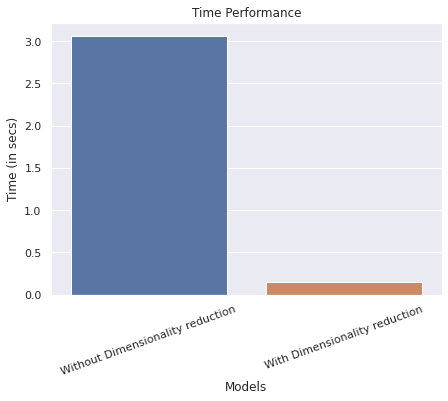

In [ ]:
#Comparing the performnce of model with dimensional reduction and model without dimensional reduction
print('Time taken for clustering without dimensionality reduction: ',round(without_dr,2),' seconds')
print('Time taken for clustering with dimensionality reduction: ',round(with_dr,2),' seconds')

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=['Without Dimensionality reduction','With Dimensionality reduction'],y=[without_dr,with_dr],palette=current_palette)
ax.set_xticklabels(['Without Dimensionality reduction','With Dimensionality reduction'], rotation= 20)
ax.set_title('Time Performance')
ax.set_xlabel('Models')
ax.set_ylabel('Time (in secs)')
plt.show()

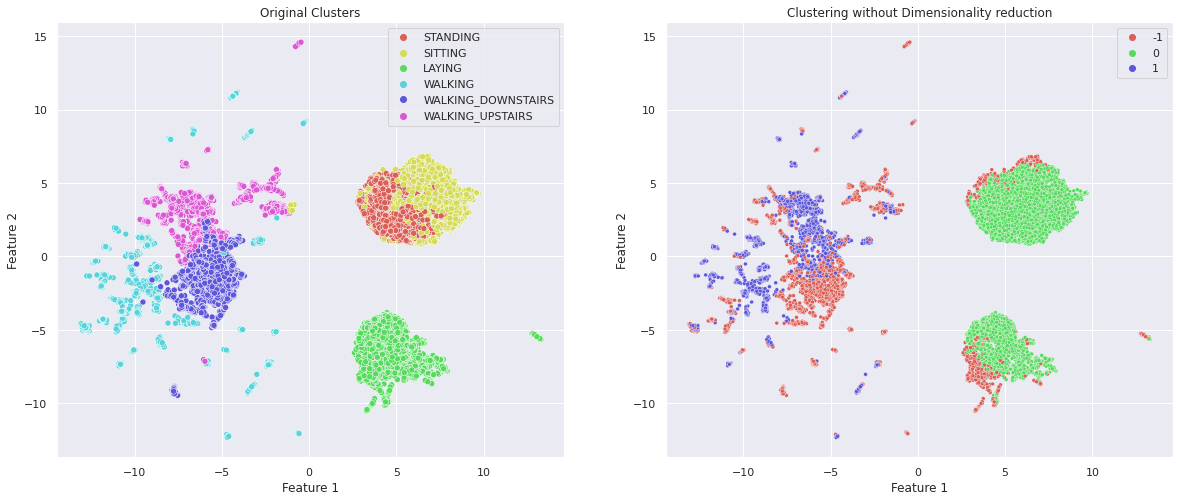

In [ ]:
#comparing original clusters with model (without Dimensionality reduction)

fig,ax = plt.subplots(1,2)
fig.set_size_inches(20,8)
sns.scatterplot(embedding[0], embedding[1],hue=label.Activity.tolist(),
                palette=sns.color_palette("hls", 6),ax=ax[0])
ax[0].set_title('Original Clusters')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')

sns.scatterplot(embedding[0], embedding[1],hue=model1.labels_,
                palette=sns.color_palette("hls", (int)(pd.DataFrame(model1.labels_).nunique())),s=15)

ax[1].set_title('Clustering without Dimensionality reduction')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')
plt.show()

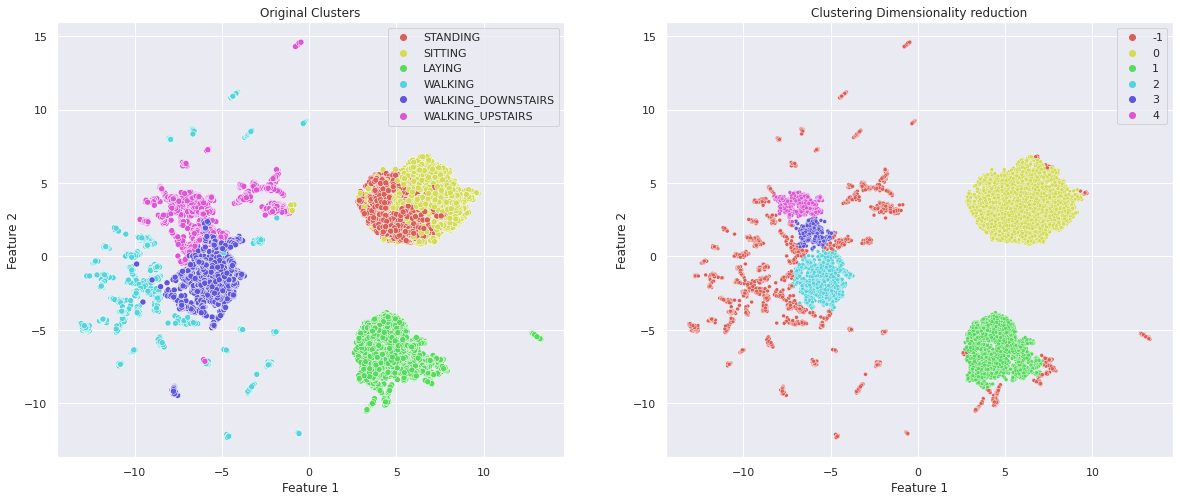

In [ ]:
#comparing original clusters with model ( with Dimensionality reduction)

fig,ax = plt.subplots(1,2)
fig.set_size_inches(20,8)
sns.scatterplot(embedding[0], embedding[1],hue=label.Activity.tolist(),
                palette=sns.color_palette("hls", 6),ax=ax[0])
ax[0].set_title('Original Clusters')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')

sns.scatterplot(embedding[0], embedding[1],hue=model2.labels_,
                palette=sns.color_palette("hls", (int)(pd.DataFrame(model2.labels_).nunique())),s=15)

ax[1].set_title('Clustering Dimensionality reduction')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')
plt.show()